# Dataset Preprocessing: Train/Dev Split + Test + Sensorial Feature Engineering

Este cuaderno realiza tres tareas principales:
1. **División Train/Dev (80/20)** estratificada por la etiqueta final (`labels_task2_1` con majority voting)
2. **Normalización y selección de features sensoriales** (ET, HR) a nivel de meme, promediando entre usuarios
3. **Procesado del conjunto de test** (sin etiquetas): misma extracción y normalización usando los parámetros ajustados sobre train

Basado en el análisis estadístico previo, **solo se conservan las features significativas**:
- **EEG:** descartado completamente (0 features significativas)


## 0. Imports y configuración

In [2]:
import json
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

INPUT_PATH = '../materials/dataset_task2_exist2026/training.json'
TEST_PATH  = '../materials/dataset_task2_exist2026/test.json'
TRAIN_OUT  = '../preprocessed_data/train_split.json'
DEV_OUT    = '../preprocessed_data/dev_split.json'
TEST_OUT   = '../preprocessed_data/test_split.json'

RANDOM_SEED = 42
DEV_SIZE    = 0.20

## 1. Carga del dataset

In [3]:
with open(INPUT_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

print(f'Total de memes en el dataset: {len(raw_data)}')
print(f'Ejemplo de claves de un meme: {list(list(raw_data.values())[0].keys())}')

Total de memes en el dataset: 2683
Ejemplo de claves de un meme: ['id_EXIST', 'lang', 'text', 'meme', 'path_memes', 'number_annotators', 'annotators', 'gender_annotators', 'age_annotators', 'ethnicities_annotators', 'study_levels_annotators', 'countries_annotators', 'sensorial', 'labels_task2_1', 'labels_task2_2', 'labels_task2_3', 'split']


## 2. Majority Voting para etiqueta final

Cada meme tiene 6 anotadores. La etiqueta final es **YES** si la mayoría vota YES, **NO** en caso contrario.  
En caso de empate exacto (3-3) se etiqueta como **YES**.

In [4]:
def majority_vote(labels: list) -> str:
    counts = Counter(labels)
    yes = counts.get('YES', 0)
    no  = counts.get('NO',  0)
    if yes > no:
        return 'YES'
    elif no > yes:
        return 'NO'
    else:
        return 'YES'

label_counts = Counter()
for meme_id, meme in raw_data.items():
    meme['final_label'] = majority_vote(meme['labels_task2_1'])
    label_counts[meme['final_label']] += 1

print('Distribución de etiquetas finales (Majority Voting):')
for label, count in label_counts.most_common():
    print(f'  {label}: {count} ({count/len(raw_data)*100:.1f}%)')

Distribución de etiquetas finales (Majority Voting):
  YES: 1603 (59.7%)
  NO: 1080 (40.3%)


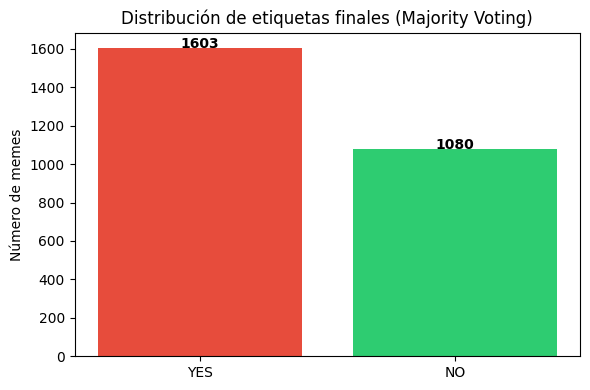

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
labels_sorted = [k for k, _ in label_counts.most_common()]
values_sorted = [label_counts[k] for k in labels_sorted]
colors = {'YES': '#e74c3c', 'NO': '#2ecc71'}
ax.bar(labels_sorted, values_sorted, color=[colors.get(l, '#3498db') for l in labels_sorted])
ax.set_title('Distribución de etiquetas finales (Majority Voting)')
ax.set_ylabel('Número de memes')
for i, v in enumerate(values_sorted):
    ax.text(i, v + 0.5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

## 3. División Train / Dev estratificada (80/20)

In [6]:
memes_ids = [mid for mid in raw_data.keys()]

y = [raw_data[mid]['final_label'] for mid in raw_data]

train_ids, dev_ids = train_test_split(
    memes_ids,
    test_size=DEV_SIZE,
    stratify=y,
    random_state=RANDOM_SEED
)

print(f'\nTrain: {len(train_ids)} memes')
print(f'Dev:   {len(dev_ids)} memes')

for split_name, ids in [('Train', train_ids), ('Dev', dev_ids)]:
    dist = Counter(raw_data[mid]['final_label'] for mid in ids)
    total = len(ids)
    print(f'\n{split_name} distribución:')
    for label, cnt in dist.most_common():
        print(f'  {label}: {cnt} ({cnt/total*100:.1f}%)')


Train: 2146 memes
Dev:   537 memes

Train distribución:
  YES: 1282 (59.7%)
  NO: 864 (40.3%)

Dev distribución:
  YES: 321 (59.8%)
  NO: 216 (40.2%)


## 4. Selección y promediado de features sensoriales

**Estrategia por meme:**
- Un meme puede tener datos de 1-4 usuarios por modalidad
- Se calcula la **media entre usuarios** para cada feature
- EEG se descarta (ninguna feature superó el test estadístico)
- Los `null` en los datos originales se tratan como NaN

In [7]:
# Features ET significativas (Mann-Whitney + FDR 5%)
ET_FEATURES = [
    'reaction_time',
    'fixations_count',
    'fixations_duration_mean_ns',
    'fixations_duration_std_ns',
    'saccades_count',
    'saccades_duration_mean_ns',
    'blinks_count',
    'blinks_duration_min_ns',
    'blinks_duration_mean_ns',
]

# Features HR (solo garmin_hr_std es significativa, resto incluidas con peso esperado menor)
HR_FEATURES = [
    'garmin_hr_std',    # ← única estadísticamente significativa
    'garmin_hr_mean',
    'garmin_hr_max',
    'garmin_hr_min',
]

# EEG: DESCARTADO

ALL_FEAT_COLS = [f'ET_{f}' for f in ET_FEATURES] + [f'HR_{f}' for f in HR_FEATURES]
print(f'Total features sensoriales seleccionadas: {len(ALL_FEAT_COLS)}')
print(f'  ET: {len(ET_FEATURES)} features')
print(f'  HR: {len(HR_FEATURES)} features (solo garmin_hr_std es significativa)')
print(f'  EEG: 0 features (descartadas por ausencia de significancia estadística)')

Total features sensoriales seleccionadas: 13
  ET: 9 features
  HR: 4 features (solo garmin_hr_std es significativa)
  EEG: 0 features (descartadas por ausencia de significancia estadística)


In [8]:
def extract_sensorial_features(meme: dict) -> dict:
    """
    Promedia las features sensoriales seleccionadas entre
    todos los usuarios disponibles para ese meme.
    Valores ausentes → NaN.
    """
    result = {}
    modalities = meme.get('sensorial', {}).get('modalities', {})

    # Eye Tracking
    et_users = modalities.get('ET', {}).get('by_user', {})
    for feat in ET_FEATURES:
        vals = [
            udata[feat] for udata in et_users.values()
            if feat in udata and udata[feat] is not None
        ]
        result[f'ET_{feat}'] = float(np.mean(vals)) if vals else np.nan

    # Heart Rate
    hr_users = modalities.get('HR', {}).get('by_user', {})
    for feat in HR_FEATURES:
        vals = [
            udata[feat] for udata in hr_users.values()
            if feat in udata and udata[feat] is not None
        ]
        result[f'HR_{feat}'] = float(np.mean(vals)) if vals else np.nan

    return result


for meme_id, meme in raw_data.items():
    meme['sensorial_features'] = extract_sensorial_features(meme)

print('Features sensoriales extraídas.')
# Mostrar ejemplo
eid = list(raw_data.keys())[0]
print(f'\nEjemplo meme {eid}:')
for k, v in raw_data[eid]['sensorial_features'].items():
    print(f'  {k}: {v:.4f}' if not np.isnan(v) else f'  {k}: NaN')

Features sensoriales extraídas.

Ejemplo meme 111269:
  ET_reaction_time: 11928.3334
  ET_fixations_count: 40.3333
  ET_fixations_duration_mean_ns: 259975250.6107
  ET_fixations_duration_std_ns: 195659979.2803
  ET_saccades_count: 39.6667
  ET_saccades_duration_mean_ns: 55395241.4056
  ET_blinks_count: 1.6666
  ET_blinks_duration_min_ns: 271145685.3334
  ET_blinks_duration_mean_ns: 278645546.6666
  HR_garmin_hr_std: 0.6401
  HR_garmin_hr_mean: 64.2083
  HR_garmin_hr_max: 65.0000
  HR_garmin_hr_min: 63.5000


## 5. Análisis de valores faltantes

In [9]:
rows = []
for meme_id, meme in raw_data.items():
    row = {
        'id':    meme_id,
        'split': 'train' if meme_id in set(train_ids) else 'dev',
        'label': meme['final_label']
    }
    row.update(meme['sensorial_features'])
    rows.append(row)

df = pd.DataFrame(rows).set_index('id')

missing_pct = df[ALL_FEAT_COLS].isnull().mean() * 100
print('% valores faltantes por feature:')
print(missing_pct.sort_values(ascending=False).to_string())

% valores faltantes por feature:
ET_blinks_count                  18.225867
ET_blinks_duration_min_ns        18.225867
ET_blinks_duration_mean_ns       18.225867
ET_fixations_count                0.000000
ET_reaction_time                  0.000000
ET_saccades_count                 0.000000
ET_fixations_duration_std_ns      0.000000
ET_fixations_duration_mean_ns     0.000000
ET_saccades_duration_mean_ns      0.000000
HR_garmin_hr_std                  0.000000
HR_garmin_hr_mean                 0.000000
HR_garmin_hr_max                  0.000000
HR_garmin_hr_min                  0.000000


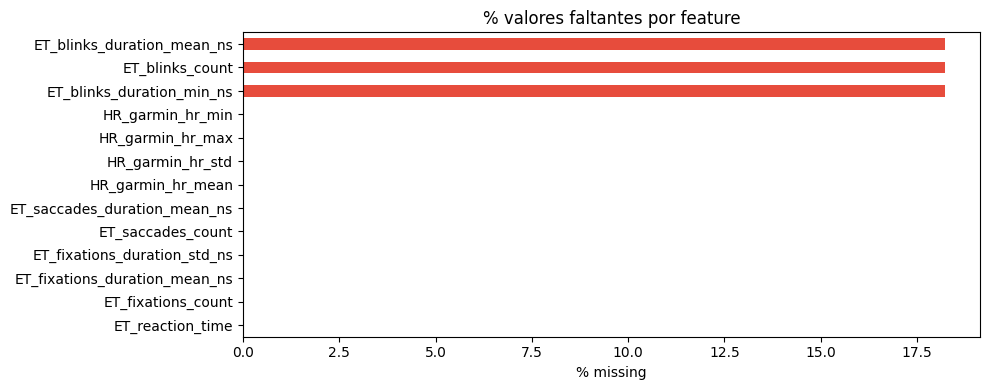

In [10]:
# Sólo mostrar el heatmap si hay suficientes memes
if len(df) <= 500:
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.heatmap(df[ALL_FEAT_COLS].isnull().T, cmap='Reds', cbar=False,
                yticklabels=ALL_FEAT_COLS, ax=ax)
    ax.set_title('Mapa de valores faltantes (rojo = NaN)')
    ax.set_xlabel('Memes')
    plt.tight_layout()
    plt.savefig('missing_heatmap.png', dpi=150)
    plt.show()
else:
    # Para datasets grandes: barplot de % missing
    fig, ax = plt.subplots(figsize=(10, 4))
    missing_pct.sort_values().plot(kind='barh', ax=ax, color='#e74c3c')
    ax.set_title('% valores faltantes por feature')
    ax.set_xlabel('% missing')
    plt.tight_layout()
    plt.show()

## 6. Imputación y Normalización Z-score

- **Imputación:** mediana calculada sobre train, aplicada a train y dev
- **Normalización:** Z-score ajustado sobre train, aplicado a train y dev  
  (evita data leakage del conjunto de validación)

In [11]:
df_train = df[df['split'] == 'train'].copy()
df_dev   = df[df['split'] == 'dev'].copy()

# Imputación con mediana de train
train_medians = df_train[ALL_FEAT_COLS].median()
df_train[ALL_FEAT_COLS] = df_train[ALL_FEAT_COLS].fillna(train_medians)
df_dev[ALL_FEAT_COLS]   = df_dev[ALL_FEAT_COLS].fillna(train_medians)

# Z-score (fit solo en train)
scaler = StandardScaler()
df_train[ALL_FEAT_COLS] = scaler.fit_transform(df_train[ALL_FEAT_COLS])
df_dev[ALL_FEAT_COLS]   = scaler.transform(df_dev[ALL_FEAT_COLS])

print('Normalización Z-score completada (sin data leakage).')
print(f'Train: {df_train.shape} | Dev: {df_dev.shape}')
print('\nEstadísticos train post-normalización (esperado: media≈0, std≈1):')
print(df_train[ALL_FEAT_COLS].describe().loc[['mean', 'std']].round(3))

Normalización Z-score completada (sin data leakage).
Train: (2146, 15) | Dev: (537, 15)

Estadísticos train post-normalización (esperado: media≈0, std≈1):
      ET_reaction_time  ET_fixations_count  ET_fixations_duration_mean_ns  \
mean               0.0                 0.0                            0.0   
std                1.0                 1.0                            1.0   

      ET_fixations_duration_std_ns  ET_saccades_count  \
mean                           0.0               -0.0   
std                            1.0                1.0   

      ET_saccades_duration_mean_ns  ET_blinks_count  \
mean                          -0.0              0.0   
std                            1.0              1.0   

      ET_blinks_duration_min_ns  ET_blinks_duration_mean_ns  HR_garmin_hr_std  \
mean                       -0.0                         0.0               0.0   
std                         1.0                         1.0               1.0   

      HR_garmin_hr_mean  HR_gar

## 7. Guardado de los JSONs de salida

In [12]:
CAPTIONS_PATH = '../materials/dataset_task2_exist2026/blip_captions_training.csv'

captions_df = pd.read_csv(CAPTIONS_PATH, dtype={'meme_id': str})
captions = dict(zip(captions_df['meme_id'], captions_df['blip_caption']))

def build_record(meme_id: str, meme: dict, norm_feats: dict) -> dict:
    return {
        'id_EXIST':                      meme['id_EXIST'],
        'lang':                          meme['lang'],
        'text':                          meme['text'],
        'meme':                          meme['meme'],
        'path_memes':                    meme['path_memes'],
        'label':                   meme['final_label'],
        'image_description':                  captions.get(meme_id, None),
        'sensorial_features_normalized': norm_feats,
    }

train_norm_dict = df_train[ALL_FEAT_COLS].to_dict(orient='index')
dev_norm_dict   = df_dev[ALL_FEAT_COLS].to_dict(orient='index')

train_output = {mid: build_record(mid, raw_data[mid], train_norm_dict[mid]) for mid in train_ids}
dev_output   = {mid: build_record(mid, raw_data[mid], dev_norm_dict[mid])   for mid in dev_ids}

with open(TRAIN_OUT, 'w', encoding='utf-8') as f:
    json.dump(train_output, f, ensure_ascii=False, indent=2)

with open(DEV_OUT, 'w', encoding='utf-8') as f:
    json.dump(dev_output, f, ensure_ascii=False, indent=2)

print(f'Guardado: {TRAIN_OUT} ({len(train_output)} memes)')
print(f'Guardado: {DEV_OUT}   ({len(dev_output)} memes)')

Guardado: ../preprocessed_data/train_split.json (2146 memes)
Guardado: ../preprocessed_data/dev_split.json   (537 memes)


## 8. Validación y resumen final

In [13]:
overlap = set(train_output) & set(dev_output)
assert len(overlap) == 0, f'ERROR: {len(overlap)} memes en ambos splits'
assert set(train_output) | set(dev_output) == set(raw_data), 'ERROR: memes sin asignar'

print('✓ Sin solapamiento entre train y dev')
print('✓ Todos los memes originales cubiertos')
print()
print('=' * 50)
print('RESUMEN FINAL')
print('=' * 50)
print(f'  Dataset original : {len(raw_data)} memes')
print(f'  Train            : {len(train_output)} ({len(train_output)/len(raw_data)*100:.1f}%)')
print(f'  Dev              : {len(dev_output)} ({len(dev_output)/len(raw_data)*100:.1f}%)')
print(f'  Features ET      : {len(ET_FEATURES)}')
print(f'  Features HR      : {len(HR_FEATURES)} (significativa: garmin_hr_std)')
print(f'  Features EEG     : 0 (descartadas)')
print(f'  Total features   : {len(ALL_FEAT_COLS)}')
print()
print('Distribución train:')
for k, v in Counter(r['label'] for r in train_output.values()).most_common():
    print(f'  {k}: {v} ({v/len(train_output)*100:.1f}%)')
print('Distribución dev:')
for k, v in Counter(r['label'] for r in dev_output.values()).most_common():
    print(f'  {k}: {v} ({v/len(dev_output)*100:.1f}%)')

✓ Sin solapamiento entre train y dev
✓ Todos los memes originales cubiertos

RESUMEN FINAL
  Dataset original : 2683 memes
  Train            : 2146 (80.0%)
  Dev              : 537 (20.0%)
  Features ET      : 9
  Features HR      : 4 (significativa: garmin_hr_std)
  Features EEG     : 0 (descartadas)
  Total features   : 13

Distribución train:
  YES: 1282 (59.7%)
  NO: 864 (40.3%)
Distribución dev:
  YES: 321 (59.8%)
  NO: 216 (40.2%)


## 9. Procesado del conjunto de Test

El test no tiene etiquetas (`labels_task2_1` ausente o vacío).  
Se aplica **exactamente la misma pipeline** que al train/dev:
- Extracción y promediado de features sensoriales (mismas features)
- Imputación con la **mediana de train** (ya calculada)
- Normalización con el **scaler ajustado sobre train** (ya ajustado)

De esta forma no hay ningún tipo de *data leakage*.

In [14]:
with open(TEST_PATH, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

In [15]:
for meme_id, meme in test_data.items():
    meme['sensorial_features'] = extract_sensorial_features(meme)

print(f'Features sensoriales extraídas para {len(test_data)} memes de test.')

Features sensoriales extraídas para 687 memes de test.


In [16]:
test_rows = []
for meme_id, meme in test_data.items():
    row = {'id': meme_id}
    row.update(meme['sensorial_features'])
    test_rows.append(row)

df_test = pd.DataFrame(test_rows).set_index('id')

missing_test = df_test[ALL_FEAT_COLS].isnull().mean() * 100
print('% valores faltantes en test:')
print(missing_test.sort_values(ascending=False).to_string())

% valores faltantes en test:
ET_blinks_count                  16.302766
ET_blinks_duration_min_ns        16.302766
ET_blinks_duration_mean_ns       16.302766
ET_fixations_count                0.000000
ET_reaction_time                  0.000000
ET_saccades_count                 0.000000
ET_fixations_duration_std_ns      0.000000
ET_fixations_duration_mean_ns     0.000000
ET_saccades_duration_mean_ns      0.000000
HR_garmin_hr_std                  0.000000
HR_garmin_hr_mean                 0.000000
HR_garmin_hr_max                  0.000000
HR_garmin_hr_min                  0.000000


In [17]:
df_test[ALL_FEAT_COLS] = df_test[ALL_FEAT_COLS].fillna(train_medians)

df_test[ALL_FEAT_COLS] = scaler.transform(df_test[ALL_FEAT_COLS])

print('\nEstadísticos test post-normalización:')
print(df_test[ALL_FEAT_COLS].describe().loc[['mean', 'std']].round(3))


Estadísticos test post-normalización:
      ET_reaction_time  ET_fixations_count  ET_fixations_duration_mean_ns  \
mean            -0.038              -0.038                          0.019   
std              1.080               1.022                          1.032   

      ET_fixations_duration_std_ns  ET_saccades_count  \
mean                         0.032             -0.040   
std                          1.140              1.025   

      ET_saccades_duration_mean_ns  ET_blinks_count  \
mean                        -0.008           -0.061   
std                          1.139            0.821   

      ET_blinks_duration_min_ns  ET_blinks_duration_mean_ns  HR_garmin_hr_std  \
mean                     -0.006                      -0.022            -0.046   
std                       1.021                       1.027             0.966   

      HR_garmin_hr_mean  HR_garmin_hr_max  HR_garmin_hr_min  
mean              0.010            -0.001             0.014  
std               1.022

In [18]:
CAPTIONS_PATH = '../materials/dataset_task2_exist2026/blip_captions_test.csv'

captions_df = pd.read_csv(CAPTIONS_PATH, dtype={'meme_id': str})
captions = dict(zip(captions_df['meme_id'], captions_df['blip_caption']))

def build_test_record(meme_id: str, meme: dict, norm_feats: dict) -> dict:
    """Estructura de salida para test (sin etiquetas)."""
    record = {
        'id_EXIST':   meme['id_EXIST'],
        'lang':       meme['lang'],
        'text':       meme['text'],
        'meme':       meme['meme'],
        'path_memes': meme['path_memes'],
        'image_description': captions.get(meme_id, None),
        'sensorial_features_normalized': norm_feats,
    }
    return record

test_norm_dict = df_test[ALL_FEAT_COLS].to_dict(orient='index')
test_output = {
    mid: build_test_record(mid, test_data[mid], test_norm_dict[mid])
    for mid in test_data
}

with open(TEST_OUT, 'w', encoding='utf-8') as f:
    json.dump(test_output, f, ensure_ascii=False, indent=2)

print(f'Guardado: {TEST_OUT} ({len(test_output)} memes)')

Guardado: ../preprocessed_data/test_split.json (687 memes)


## 10. Resumen global de los tres splits

In [19]:
print('=' * 55)
print('RESUMEN GLOBAL')
print('=' * 55)
print(f'  Train original : {len(raw_data)} memes')
print(f'  → train_split  : {len(train_output)} memes ({len(train_output)/len(raw_data)*100:.1f}%)')
print(f'  → dev_split    : {len(dev_output)} memes ({len(dev_output)/len(raw_data)*100:.1f}%)')
print(f'  Test           : {len(test_output)} memes (sin etiquetas)')
print()
print(f'  Features ET    : {len(ET_FEATURES)}')
print(f'  Features HR    : {len(HR_FEATURES)} (significativa: garmin_hr_std)')
print(f'  Features EEG   : 0 (descartadas)')
print(f'  Total features : {len(ALL_FEAT_COLS)}')
print()
print('  Normalización  : Z-score (fit=train, transform=train/dev/test)')
print('  Imputación NaN : mediana de train')
print()
print('Archivos generados:')
print(f'  ✓ {TRAIN_OUT}')
print(f'  ✓ {DEV_OUT}')
print(f'  ✓ {TEST_OUT}')

RESUMEN GLOBAL
  Train original : 2683 memes
  → train_split  : 2146 memes (80.0%)
  → dev_split    : 537 memes (20.0%)
  Test           : 687 memes (sin etiquetas)

  Features ET    : 9
  Features HR    : 4 (significativa: garmin_hr_std)
  Features EEG   : 0 (descartadas)
  Total features : 13

  Normalización  : Z-score (fit=train, transform=train/dev/test)
  Imputación NaN : mediana de train

Archivos generados:
  ✓ ../preprocessed_data/train_split.json
  ✓ ../preprocessed_data/dev_split.json
  ✓ ../preprocessed_data/test_split.json
